# Figure 9: Probability first outbreak observed in each neighbourhood

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import time
import numpy as np
import pylab as plt
import random
import multiprocessing as mp
from scipy.optimize import fsolve
import pandas as pd

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_model_6neigh
import Gillespie_household_6neigh_first   # only records first neighbourhood outbreak
import R_star_construct

importlib.reload(Gillespie_household_model_6neigh)
importlib.reload(Gillespie_household_6neigh_first)
importlib.reload(R_star_construct)

do_Gillespie = Gillespie_household_model_6neigh.do_Gillespie
do_Gillespie_first = Gillespie_household_6neigh_first.do_Gillespie
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2,h3,h4,h5,h6 = 2520,2520,1260,1260,840,840      # no. of households in each neighbourhood
n1,n2,n3,n4,n5,n6 = 2,2,4,4,6,6                      # size of households for each neighbourhood
N_neigh = 6

gamma = 0.2                                                 # recovery rate from infection
days = 100                                                  # no. of days in simulation
tStart, tEnd = 0, days                                      # start time and end time (days) of simulation

time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000

H = np.array([h1,h2,h3,h4,h5,h6])
N = np.array([n1,n2,n3,n4,n5,n6])

In [4]:
nu = 3      # good range 1 to 6 (2 to 4)
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu

alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Run sims for 6 neighbourhoods

#### Comparing for different $\nu$

In [5]:
nu_results = np.zeros((3,N_neigh))   # initialise array to store results for each nu value
nu_var = [1,3,5]                     # list of nu values
obs_len = np.zeros(3)                 # initialise array to store length of results for each nu value

t = time.process_time()       # recording how long runs for

for n in range(len(nu_var)):   # looping over different nu values
    nu = nu_var[n]
    beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]   # finding beta value for specified nu
    alpha = beta/nu                              # finding alpha
    alpha = round(alpha,2)   # rounding to 2 dp.
    beta = round(beta,2)
    
    obs_outbreak = np.zeros(chains)    # initialising array to unpack results into
    
    alpha_vec = np.zeros(chains, dtype=object) # intialising array to store each set of alpha values
                                           # we simulate proportion of contacts reserved for ones own 
    for chain in range(chains):                # neighbourhood each run  

        p_weak = np.random.uniform(0.4,0.5,1)[0] # realisation of r for weakly connected neighbourhoods
        p_strong = np.random.uniform(0,0.1,1)[0] # realisation of r for strongly connected neighbourhoods

        p_reserve = np.array([p_strong,p_weak,p_strong,p_weak,p_strong,p_weak])
        rho = np.zeros((N_neigh,N_neigh))

        for i in range(N_neigh):   # using the r values to calculate the rho values
            for j in range(N_neigh):
                rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
            rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))
        alpha_vec[chain] = alpha*rho   # saving all 'alpha' vectors for each simulation run


    pool = mp.Pool(mp.cpu_count())  # start paralellisation

    Infs = np.zeros(N_neigh)
    Infs[0] = 1                   # not actually needed just left in code atm

    params_dict = {'beta': [beta,beta,beta,beta,beta,beta], 
               'gamma':gamma,
               'n': N, 
               'h': H,
               'inf0': Infs,
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
    # we create a seperate dictionary containing the alpha values for each run and then merge the 2 together    
    neigh6_results0 = pool.map(do_Gillespie_first, [{**params_dict,**{'alpha': alpha_vec[i]}} for i in range(chains)])

    pool.close()    # end paralellisation

    for i in range(chains):
        obs_outbreak[i] = neigh6_results0[i][0]
    obs_outbreak = [out for out in obs_outbreak if out != 7]
    # record probability of outbreak first being observed in each neighbourhood for each nu value
    nu_results[n,:] = np.bincount(obs_outbreak,minlength=6)/len(obs_outbreak)
    obs_len[n] = len(obs_outbreak)  # record length of results for each nu value

elapsed_time = time.process_time() - t     # record time took to run
print("elapsed time: ", elapsed_time)

elapsed time:  41.609375


### Saving / loading the results

In [6]:
# save results so don't have to keep rerunning
np.savetxt('nu_results.csv', nu_results, delimiter=',')
np.savetxt('obs_len.csv', obs_len, delimiter=',')

In [7]:
nu_results = pd.read_csv('nu_results.csv',header=None)
nu_results = np.array(nu_results)
nu_results
obs_len = pd.read_csv('obs_len.csv',header=None)
obs_len = np.array(obs_len)
obs_len

array([[31181.],
       [36855.],
       [39287.]])

### Producing figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


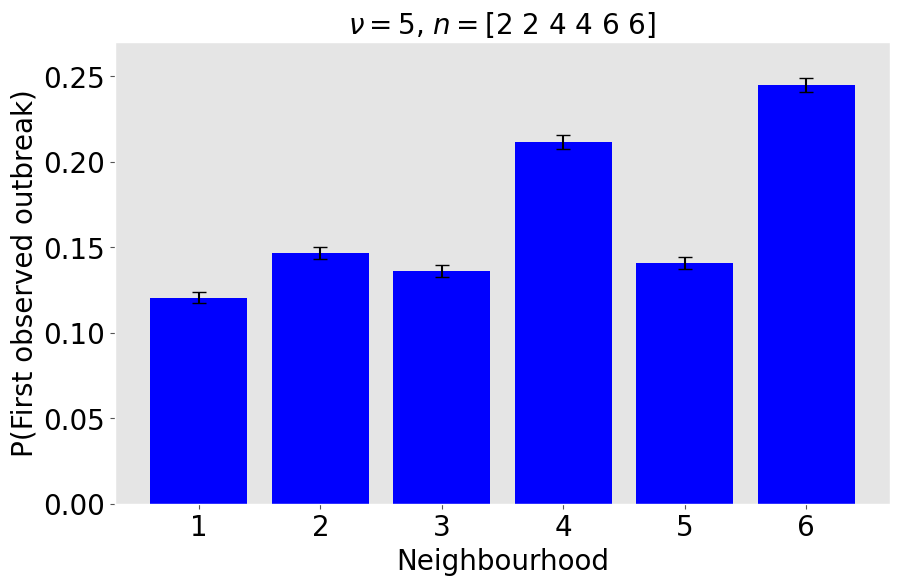

In [11]:
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(10, 6))
heights_b = nu_results[1, :]  # nu=1  red

# Calculate standard error
std_err = np.sqrt((heights_b * (1 - heights_b)) / obs_len[2])

# Calculate confidence intervals (95% confidence level)
conf_intervals = std_err * stats.norm.ppf(1 - 0.05 / 2)

# Plot bar chart with error bars
plt.style.use('ggplot')

x = ['1', '2', '3', '4', '5', '6']
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, heights_b, color='blue', yerr=conf_intervals, capsize=5)
plt.xlabel("Neighbourhood", fontsize=20, color='black')
plt.ylabel('P(First observed outbreak)', fontsize=20, color='black')
plt.grid(False)
plt.xticks(x_pos, x, fontsize=20, color='black')
plt.yticks(fontsize=20, color='black')
plt.ylim(0, 0.27)
plt.title(r'$\nu=${}, $n=${}'.format(nu, N), fontsize=20)
plt.savefig('prob_obs_out_range.pdf', bbox_inches='tight')

plt.show()

### Producing figure

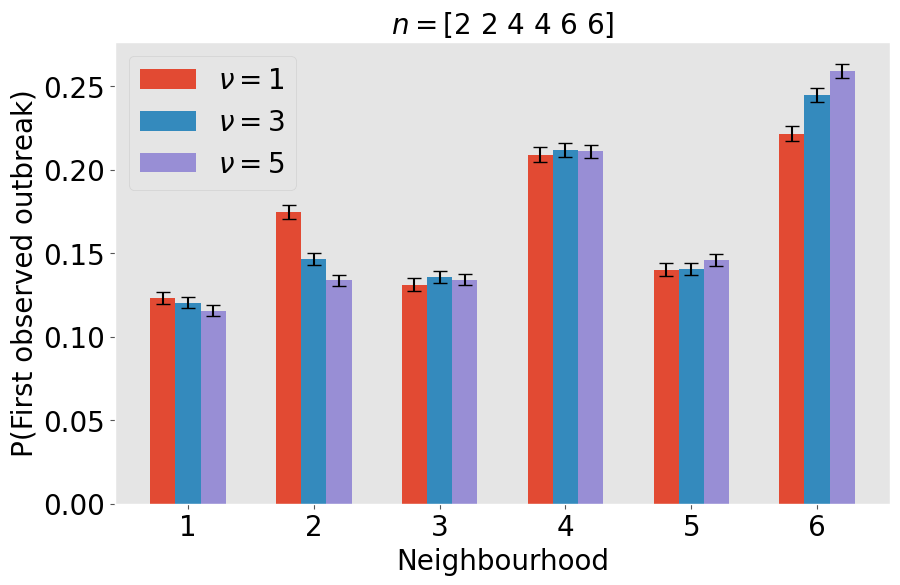

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

heights_a = nu_results[0, :]  # nu=1  red
heights_b = nu_results[1, :]  # nu=3  blue
heights_c = nu_results[2, :]  # nu=5  purple

# Calculate the standard error for each set of heights
std_err_a = np.sqrt((heights_a * (1 - heights_a)) / obs_len[0])
std_err_b = np.sqrt((heights_b * (1 - heights_b)) / obs_len[1])
std_err_c = np.sqrt((heights_c * (1 - heights_c)) / obs_len[2])

# Calculate the confidence intervals (95% confidence level)
z_score = stats.norm.ppf(1 - 0.05 / 2)
conf_intervals_a = std_err_a * z_score
conf_intervals_b = std_err_b * z_score
conf_intervals_c = std_err_c * z_score

position = np.arange(N_neigh)
colors = ['C0', 'C1', 'C2']
width = 0.2  # Width of each bar

plt.figure(figsize=(10, 6))

# Adjust positions for side-by-side bars
positions_a = position - width
positions_b = position
positions_c = position + width

plt.style.use('ggplot')

# Plot bars side by side with error bars
plt.bar(positions_a, heights_a, width=width, color=colors[0], yerr=conf_intervals_a, capsize=5, label=r'$\nu=1$')
plt.bar(positions_b, heights_b, width=width, color=colors[1], yerr=conf_intervals_b, capsize=5, label=r'$\nu=3$')
plt.bar(positions_c, heights_c, width=width, color=colors[2], yerr=conf_intervals_c, capsize=5, label=r'$\nu=5$')

plt.xlabel('Neighbourhood', fontsize=20, color='black')
plt.ylabel('P(First observed outbreak)', fontsize=20, color='black')
plt.grid(False)
plt.xticks(position, [1, 2, 3, 4, 5, 6], fontsize=20, color='black')
plt.yticks(fontsize=20, color='black')
#plt.ylim(0, 0.27)
plt.title(r'$n=${}'.format(N), fontsize=20)
plt.legend(fontsize=20)
plt.savefig('prob_obs_out_range_nus.pdf', bbox_inches='tight')

plt.show()